In [1]:
from IPython.display import SVG
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Activation, add, Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import model_to_dot, plot_model
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.python.client import device_lib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7084082618335300217, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5956834645192690220
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17163276474129383766
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10185667557451325392
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 22s 0us/step


In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [0]:
x_train = x_train / 255
x_test = x_test / 255

In [6]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
mean, std

(0.4733630004850874, 0.25156892506322026)

In [0]:
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)
x_train -= mean
x_test -= mean

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:
# def residual_block(input_layer, channels_in, channels_out, stride=(1,1), proj_shortcut=False, bottleneck=False):
#     shortcut = input_layer

#     first_kernel=(3,3)
#     first_strides=stride

#     fixed_strides=(1,1)
#     fixed_kernel=(1,1)

#     if bottleneck:
#         first_kernel=(1,1)
#         first_strides=(1,1)

#     y = Conv2D(channels_in, kernel_size=first_kernel, strides=first_strides, padding='same')(input_layer)
#     y = norm_and_activation(y)

#     if bottleneck:
#         y = grouped_convolution(y, channels_in, stride)
#         y = norm_and_activation(y)

#     y = Conv2D(channels_out, kernel_size=first_kernel, strides=fixed_strides, padding='same')(y)
#     y = norm(y)

#     if proj_shortcut or stride != fixed_strides:
#         shortcut = Conv2D(channels_out, kernel_size=fixed_kernel, strides=stride, padding='same')(shortcut)
#         shortcut = norm(shortcut)

#     print(proj_shortcut, stride, shortcut.shape, y.shape)
#     y = add([shortcut, y])
#     y = norm_and_activation(y, False)

#     return y

In [0]:
def dynamic_lr(epoch):
    lr = 0.5e-3
    if epoch > 25:
      lr *= 1e-1
    elif epoch > 50:
      lr *= 1e-2
    elif epoch > 75:
      lr *= 1e-3
    print('Learning rate: ', lr)
    return lr

In [0]:
def norm_and_activation(input_layer, norm=True, activate=True):
    if norm:
        input_layer = BatchNormalization()(input_layer)
    if activate:
        input_layer = Activation('relu')(input_layer)
    return input_layer

In [0]:
def residual_block(input_layer, channels_in, channels_out, stride=(1,1), proj_short=False, bottleneck=False):
    short_path = input_layer
    y = input_layer
    y = norm_and_activation(y, False, True)
    y = Conv2D(channels_in, kernel_size=(1,1), strides=stride, padding='same')(y)
    print('sub_block_1, [ 1x1,', channels_in, ']')
    y = norm_and_activation(y)
    y = Conv2D(channels_in, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    print('sub_block_2, [ 3x3,', channels_in, ']')
    y = norm_and_activation(y)
    y = Conv2D(channels_out, kernel_size=(1,1), strides=(1,1), padding='same')(y)
    print('sub_block_3, [ 1x1,', channels_out, ']')
    if proj_short or stride != (1,1):
        short_path = Conv2D(channels_out, kernel_size=(1,1), strides=stride, padding='same')(short_path)
        short_path = norm_and_activation(short_path, True, False)
    y = add([short_path, y])
    y = norm_and_activation(y, False, True)
    print('First layer', proj_short, ', Stride size', stride, ', Shape', y.shape)

    return y

In [0]:
def model(conv_size, lr, input_shape, bottleneck=False):
    conv_size_double = conv_size * 4
    initial = Input(shape=input_shape)

    conv_11 = Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(initial)
    conv_11 = norm_and_activation(conv_11)

    pool_1 = MaxPooling2D((2, 2), padding='valid')(conv_11)

    block_11 = residual_block(pool_1, channels_in=conv_size, channels_out=conv_size_double, proj_short=True, bottleneck=bottleneck)
    block_12 = residual_block(block_11, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_13 = residual_block(block_12, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)

    conv_size *= 2
    conv_size_double *= 2
    
    block_21 = residual_block(block_13, channels_in=conv_size, channels_out=conv_size_double, stride=(2,2), bottleneck=bottleneck)
    block_22 = residual_block(block_21, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_23 = residual_block(block_22, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_24 = residual_block(block_23, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)

    conv_size *= 2
    conv_size_double *= 2
    
    block_31 = residual_block(block_24, channels_in=conv_size, channels_out=conv_size_double, stride=(2,2), bottleneck=bottleneck)
    block_32 = residual_block(block_31, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_33 = residual_block(block_32, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_34 = residual_block(block_33, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_35 = residual_block(block_34, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_36 = residual_block(block_35, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)

    conv_size *= 2
    conv_size_double *= 2
    
    block_41 = residual_block(block_36, channels_in=conv_size, channels_out=conv_size_double, stride=(2,2), bottleneck=bottleneck)
    block_42 = residual_block(block_41, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
    block_43 = residual_block(block_42, channels_in=conv_size, channels_out=conv_size_double, bottleneck=bottleneck)
  
    pool_21 = GlobalAveragePooling2D()(block_43)

    hidden_1 = Dense(1000, kernel_initializer='random_uniform', activation='relu')(pool_21)
    predictions = Dense(10, activation='softmax')(hidden_1)
    model = Model(inputs=initial, outputs=predictions)
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=True)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = model(64, dynamic_lr(0), (32,32,3), True)

Learning rate:  0.0005
sub_block_1, [ 1x1, 64 ]
sub_block_2, [ 3x3, 64 ]
sub_block_3, [ 1x1, 256 ]
First layer True , Stride size (1, 1) , Shape (?, 8, 8, 256)
sub_block_1, [ 1x1, 64 ]
sub_block_2, [ 3x3, 64 ]
sub_block_3, [ 1x1, 256 ]
First layer False , Stride size (1, 1) , Shape (?, 8, 8, 256)
sub_block_1, [ 1x1, 64 ]
sub_block_2, [ 3x3, 64 ]
sub_block_3, [ 1x1, 256 ]
First layer False , Stride size (1, 1) , Shape (?, 8, 8, 256)
sub_block_1, [ 1x1, 128 ]
sub_block_2, [ 3x3, 128 ]
sub_block_3, [ 1x1, 512 ]
First layer False , Stride size (2, 2) , Shape (?, 4, 4, 512)
sub_block_1, [ 1x1, 128 ]
sub_block_2, [ 3x3, 128 ]
sub_block_3, [ 1x1, 512 ]
First layer False , Stride size (1, 1) , Shape (?, 4, 4, 512)
sub_block_1, [ 1x1, 128 ]
sub_block_2, [ 3x3, 128 ]
sub_block_3, [ 1x1, 512 ]
First layer False , Stride size (1, 1) , Shape (?, 4, 4, 512)
sub_block_1, [ 1x1, 128 ]
sub_block_2, [ 3x3, 128 ]
sub_block_3, [ 1x1, 512 ]
First layer False , Stride size (1, 1) , Shape (?, 4, 4, 512)
sub_

In [15]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
plot_model(model, to_file='resnet50_cifar10.png', show_shapes=True, show_layer_names=True)

In [0]:
svg_plot = model_to_dot(model).create(prog='dot', format='svg')

In [0]:
with open('svg_plot.svg', 'wb') as file:
    file.write(svg_plot)

In [0]:
epochs = 100
batch_size = 512

In [0]:
checkpoint = ModelCheckpoint('resnet50_cifar10_weights_{epoch:04d}_{acc:.4f}.h5', save_weights_only=True, period=10, verbose=1)

In [21]:
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[checkpoint])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 62s 2ms/step - loss: 1.8340 - acc: 0.3779 - val_loss: 1.6373 - val_acc: 0.4087
Epoch 2/100
40000/40000 [==============================] - 39s 969us/step - loss: 1.2166 - acc: 0.5638 - val_loss: 1.4807 - val_acc: 0.4882
Epoch 3/100
40000/40000 [==============================] - 39s 979us/step - loss: 0.9131 - acc: 0.6760 - val_loss: 1.4816 - val_acc: 0.4903
Epoch 4/100
40000/40000 [==============================] - 39s 980us/step - loss: 0.6794 - acc: 0.7614 - val_loss: 1.4012 - val_acc: 0.5647
Epoch 5/100
40000/40000 [==============================] - 39s 980us/step - loss: 0.4916 - acc: 0.8279 - val_loss: 1.6002 - val_acc: 0.5460
Epoch 6/100
40000/40000 [==============================] - 39s 980us/step - loss: 0.3784 - acc: 0.8678 - val_loss: 1.6103 - val_acc: 0.5584
Epoch 7/100
40000/40000 [==============================] - 39s 981us/step - loss: 0.2935 - acc: 0.8977 - val_los

In [22]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Acc', scores[1], 'Loss', scores[0])

Acc 0.6645 Loss 2.309853343009949


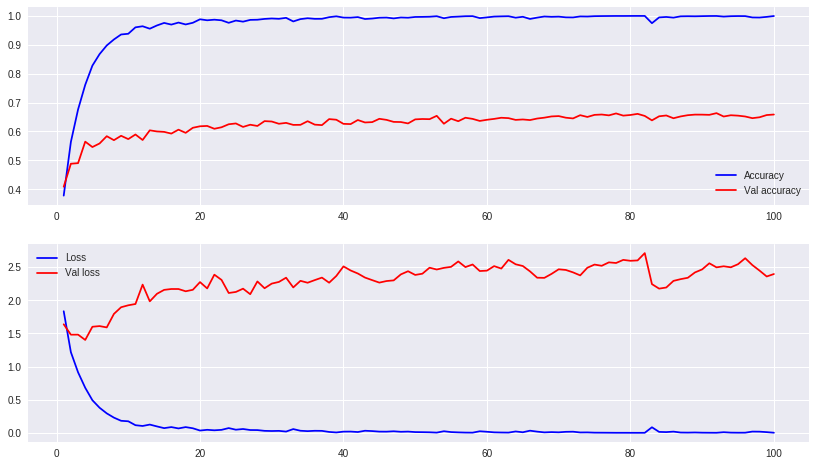

In [23]:
epochs_list = [i+1 for i in range(epochs)]
plt.figure(figsize=(14,8))
plt.subplot(211)
plt.plot(epochs_list, history.history['acc'], 'b-', label='Accuracy')
plt.plot(epochs_list, history.history['val_acc'], 'r-', label='Val accuracy')
plt.legend()
plt.subplot(212)
plt.plot(epochs_list, history.history['loss'], 'b-', label='Loss')
plt.plot(epochs_list, history.history['val_loss'], 'r-', label='Val loss')
plt.legend()
plt.show()

In [0]:
model.save_weights("resnet50_cifar10_weights.h5")